In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datajoint as dj
import scipy.signal as signal
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import matplotlib
%matplotlib notebook
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['legend.frameon'] = False

In [3]:
dj.conn('at-database.ad.bcm.edu')

Please enter DataJoint username: shan
Please enter DataJoint password: ········
Connecting shan@at-database.ad.bcm.edu:3306


DataJoint connection (connected) shan@at-database.ad.bcm.edu:3306

In [4]:
info_schema = dj.schema('shan_info')

In [5]:
info = dj.create_virtual_module(module_name='info',schema_name='shan_info')
slicepatch = dj.create_virtual_module(module_name='slicepatch', schema_name='shan_slice_patch')
common = dj.create_virtual_module(module_name='common', schema_name='common')

In [6]:
slicepatch.PeriLedAll()

animal_id id (internal to database),injection_id number of injection,slice_id slice number from lateral to medial,cell_id 1 to 8,trace_idx trace number,peri_led_win positive peri window durations [w1 w2](-w1:+w2) in ms,peri_led_spk binary spike train around led onset,"peri_led_led binary time series indicating led status: 1 = led on, 0 = led off","peri_led_time new time, 0 for LED starting point","peri_led_on_time absolute time of led on, in ms","peri_led_dur duration of LED stimulation, in ms","peri_led_delay delay time between LED and ephys, in ms"
2704,1,1,3,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.96000000000001,20.03999999999999,50.00000000000001
2704,1,1,3,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,100.0,20.0,50.04
2704,1,1,3,3,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.96000000000001,20.03999999999999,50.00000000000001
2704,1,1,3,4,=BLOB=,=BLOB=,=BLOB=,=BLOB=,100.0,20.0,50.04
2704,1,1,3,5,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.96000000000001,20.03999999999999,50.00000000000001
2704,1,1,3,6,=BLOB=,=BLOB=,=BLOB=,=BLOB=,100.0,20.0,50.04
2704,1,1,3,7,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.96000000000001,20.03999999999999,50.00000000000001
2704,1,1,3,8,=BLOB=,=BLOB=,=BLOB=,=BLOB=,100.0,20.0,50.04
2704,1,1,3,9,=BLOB=,=BLOB=,=BLOB=,=BLOB=,99.96000000000001,20.03999999999999,50.00000000000001
2704,1,1,3,10,=BLOB=,=BLOB=,=BLOB=,=BLOB=,100.0,20.0,50.04


# PSTH and scatter plot for sharpenning

In [7]:
def compute_spk_density(query):

    spkcount_on, time = \
        (slicepatch.PeriLedSetAnalysis & query & 'led_stat_id = 1').fetch1(
            'spk_count', 'time')
    spkcount_off = \
        (slicepatch.PeriLedSetAnalysis & query & 'led_stat_id = 3').fetch1('spk_count')

    dt = np.divide(np.mean(np.diff(time)), 1000)

    window_size = 100
    spkcount_on_conv = [np.divide(signal.convolve(spkcount, signal.boxcar(window_size), 
                                                mode='same'), window_size*dt) 
                        for spkcount in spkcount_on]
    spkcount_off_conv = [np.divide(signal.convolve(spkcount, signal.boxcar(window_size), 
                                                mode='same'), window_size*dt) 
                        for spkcount in spkcount_off]
    mean_spk_counts = np.vstack([np.squeeze(np.mean(spkcount_on_conv, axis=0)),
                                 np.squeeze(np.mean(spkcount_off_conv, axis=0))])

    sem_spk_counts = np.vstack([np.squeeze(np.divide(np.std(spkcount_on_conv, axis=0), 
                                                     np.sqrt(len(spkcount_on_conv)))),
                                np.squeeze(np.divide(np.std(spkcount_off_conv, axis=0), 
                                                     np.sqrt(len(spkcount_off_conv))))])

    return np.squeeze(time), mean_spk_counts, sem_spk_counts

In [8]:
def get_spk_delay(area, layer):

    injections = info.Injections & 'injection_site="{}"'.format(area)
    animals = common.Animal & injections & 'animal_id!=3024'
    cells = slicepatch.Cell & animals & 'cell_type_gene = "pyr" '& 'cell_layer = "{}"'.format(layer)

    conds, mean_delay = (slicepatch.PairwiseSpkDelay & cells).fetch('spk_delay_conds', 'spk_delay_mean')
    
    spk_delay_mat_on = []
    spk_delay_mat_off = []

    for icell, spk_delay in enumerate(mean_delay):
        delay = np.squeeze(spk_delay)
        cond = np.squeeze(conds[icell])

        if 1 in cond and 3 in cond:
            spk_delay_mat_off.append(delay[cond==1])
            spk_delay_mat_on.append(delay[cond==3])

    return np.squeeze(spk_delay_mat_on), np.squeeze(spk_delay_mat_off)

## PSTH for excitatory cells in each layer - Figure 4B

In [9]:
pos = dict(left=0.15, top=0.95, bottom=0.08, right=0.9)

<IPython.core.display.Javascript object>


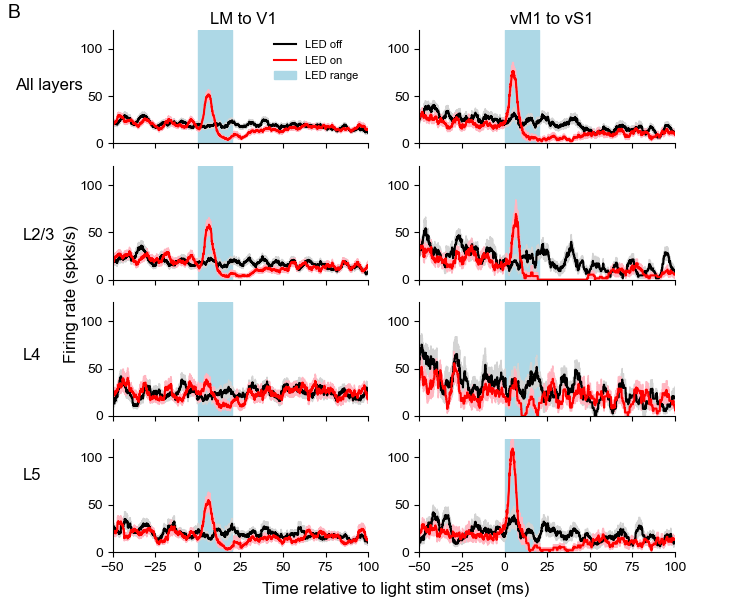

Text(0.03, 0.2, 'L5')

In [10]:
fig, axs = plt.subplots(4, 2, sharex=True, figsize=(7.5, 6))

# plot sharpening PTSH
peri_led_set_ids = np.arange(8) + 1
x_lim = [-50, 100]
y_lim = [0, 120]
fsize_label = 12

labels = ['LED off', 'LED on']
mean_color = ['black', 'red']
sem_color = ['lightgray', 'lightpink']

for iax, ax in enumerate(axs.flatten()):

    query = f'peri_led_set_id = {peri_led_set_ids[iax]}'
    time, mean_spk_counts, sem_spk_counts = compute_spk_density(query)

    ax.fill_between([0, 20], [y_lim[0], y_lim[0]], [y_lim[1], y_lim[1]], 
                        color='lightblue', label='LED range')
    for i in [0, 1]:

        ax.fill_between(time, mean_spk_counts[i]+sem_spk_counts[i], mean_spk_counts[i]-sem_spk_counts[i], 
                        color=sem_color[i])
        ax.plot(time, mean_spk_counts[i], color=mean_color[i], label=labels[i])

    ax.set_xlim(x_lim[0], x_lim[1])
    ax.set_ylim(y_lim[0], y_lim[1])

    if iax == 0:
        ax.legend(loc='best', fontsize=8, )
        
fig.subplots_adjust(**pos)

fig.text(0.35, 0.01, r'Time relative to light stim onset (ms)', fontsize=fsize_label)
fig.text(0.085, 0.4, r'Firing rate (spks/s)', rotation='vertical', fontsize=fsize_label)

# add panel label
fig.text(0.01, 0.97, 'B', fontsize=14)
fig.text(0.28, 0.96, r'LM to V1', fontsize=fsize_label)
fig.text(0.68, 0.96, r'vM1 to vS1', fontsize=fsize_label)

layer_label_left = 0.03
fig.text(0.02, 0.85, 'All layers', fontsize=fsize_label)
fig.text(layer_label_left, 0.6, r'L2/3', fontsize=fsize_label)
fig.text(layer_label_left, 0.4, r'L4', fontsize=fsize_label)
fig.text(layer_label_left, 0.2, r'L5', fontsize=fsize_label)

## Scatter plot for spike delay

<IPython.core.display.Javascript object>


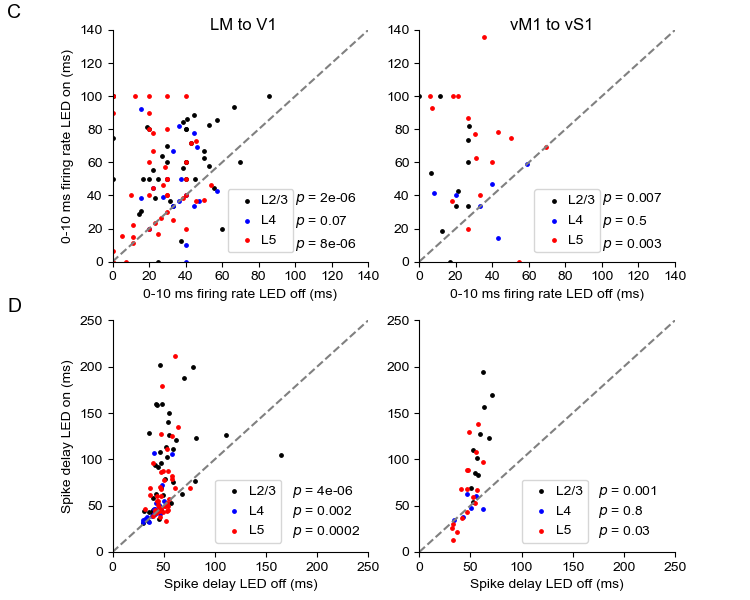

/Users/shanshen/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/shanshen/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [11]:
fig, axs = plt.subplots(2, 2, figsize=(7.5, 6))

areas = ['LM', 'vM1']

x_lim_exc = [0, 140]
y_lim_exc = [0, 140]

x_lim_delay = [0, 250]
y_lim_delay = [0, 250]

legend_loc_exc = [0.45, 0.04]
legend_loc_delay = [0.4, 0.04]
p_loc_x_exc = 100
p_loc_x_delay = 175

marker_size = 6

for iax, ax in enumerate(axs.flatten()[0:2]):
    
    sharp_L23 = pd.read_csv(f'data/sharpening_{areas[iax]}_L23.csv')
    sharp_L4 = pd.read_csv(f'data/sharpening_{areas[iax]}_L4.csv')
    sharp_L5 = pd.read_csv(f'data/sharpening_{areas[iax]}_L5.csv')
    
    
    ax.scatter(sharp_L23['fr_off'], sharp_L23['fr_on'], s=marker_size, color='black', label='L2/3')
    ax.scatter(sharp_L4['fr_off'], sharp_L4['fr_on'], s=marker_size, color='blue', label='L4')
    ax.scatter(sharp_L5['fr_off'], sharp_L5['fr_on'], s=marker_size, color='red', label='L5')
    
    stat_L23, p_L23 = stats.wilcoxon(sharp_L23['fr_off'], sharp_L23['fr_on'])
    stat_L4, p_L4 = stats.wilcoxon(sharp_L4['fr_off'], sharp_L4['fr_on'])
    stat_L5, p_L5 = stats.wilcoxon(sharp_L5['fr_off'], sharp_L5['fr_on'])
    
    # add refline
    ax.plot(x_lim_exc, y_lim_exc, linestyle='--', color='gray')
    
    ax.set_xlim(x_lim_exc[0], x_lim_exc[1])
    ax.set_ylim(y_lim_exc[0], y_lim_exc[1])
    
    ax.set_xlabel(r'0-10 ms firing rate LED off (ms)')
    
    if iax == 0:
        ax.set_ylabel(r'0-10 ms firing rate LED on (ms)')
    
    ax.legend(loc=legend_loc_exc, handletextpad=0, frameon=True)
    ax.text(p_loc_x_exc, 36, r'$p$ = {}'.format(format(p_L23, '.1g')))
    ax.text(p_loc_x_exc, 22, r'$p$ = {}'.format(format(p_L4, '.1g')))
    ax.text(p_loc_x_exc, 8, r'$p$ = {}'.format(format(p_L5, '.1g')))
    ax.set_xticks(np.arange(0, 160, 20))
    
for iax, ax in enumerate(axs.flatten()[2:4]):
    sharp_L23 = pd.read_csv(f'data/sharpening_{areas[iax]}_L23.csv')
    sharp_L4 = pd.read_csv(f'data/sharpening_{areas[iax]}_L4.csv')
    sharp_L5 = pd.read_csv(f'data/sharpening_{areas[iax]}_L5.csv')
    ax.scatter(sharp_L23['delay_off'], sharp_L23['delay_on'], s=marker_size, color='black', label='L2/3')
    ax.scatter(sharp_L4['delay_off'], sharp_L4['delay_on'], s=marker_size, color='blue', label='L4')
    ax.scatter(sharp_L5['delay_off'], sharp_L5['delay_on'], s=marker_size, color='red', label='L5')
    
    stat_L23, p_L23 = stats.wilcoxon(sharp_L23['delay_off'], sharp_L23['delay_on'])
    stat_L4, p_L4 = stats.wilcoxon(sharp_L4['delay_off'], sharp_L4['delay_on'])
    stat_L5, p_L5 = stats.wilcoxon(sharp_L5['delay_off'], sharp_L5['delay_on'])
    # add refline
    ax.plot(x_lim_delay, y_lim_delay, linestyle='--', color='gray')
    
    ax.set_xlim(x_lim_delay[0], x_lim_delay[1])
    ax.set_ylim(y_lim_delay[0], y_lim_delay[1])
    
    ax.set_xlabel(r'Spike delay LED off (ms)')
    
    if iax == 0:
        ax.set_ylabel(r'Spike delay LED on (ms)')
        
    ax.legend(loc=legend_loc_delay, handletextpad=0.05, frameon=True)
    ax.text(p_loc_x_delay, 62, r'$p$ = {}'.format(format(p_L23, '.1g')))
    ax.text(p_loc_x_delay, 40, r'$p$ = {}'.format(format(p_L4, '.1g')))
    ax.text(p_loc_x_delay, 18, r'$p$ = {}'.format(format(p_L5, '.1g')))

fig.subplots_adjust(left=0.17, right=0.9)
fig.tight_layout()
fig.text(0.01, 0.97, 'C', fontsize=14)
fig.text(0.01, 0.48, 'D', fontsize=14)


fig.text(0.28, 0.95, r'LM to V1', fontsize=fsize_label)
fig.text(0.68, 0.95, r'vM1 to vS1', fontsize=fsize_label)

fig.subplots_adjust(**pos)


## Statistical test for spike delay

In [12]:
areas = ['LM', 'vM1']
layers = ['L23', 'L4', 'L5']
spk_delay_stats = []
for area in areas:
    for layer in layers:
        delay_on, delay_off = get_spk_delay(area, layer)
        s, p = stats.ttest_ind(delay_on[1:], delay_off[1:], nan_policy='omit')
        result = {
            'area': area,
            'layer': layer,
            'p_value': p,
            'mean_delay_on': np.nanmean(delay_on),
            'mean_delay_off': np.nanmean(delay_off)
        }
        spk_delay_stats.append(result)

In [13]:
df_delay_stats = pd.DataFrame(spk_delay_stats)
df_delay_stats

,area,layer,p_value,mean_delay_on,mean_delay_off
0,LM,L23,0.002821,97.690387,66.700700
1,LM,L4,0.146505,52.026312,43.235285
2,LM,L5,0.001216,67.835310,50.475461
3,vM1,L23,0.001499,117.359071,61.337985
4,vM1,L4,0.968212,50.087701,50.845236
5,vM1,L5,0.070712,75.229549,66.947909
